这个程序只考虑movement矩阵的位置信息，不考虑速度信息，并且不对原矩阵做PCA；单个时间点会强行扩展为多个以伪造高维数据，

In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA
from matplotlib.collections import LineCollection
import pandas as pd

import scipy.io

In [2]:
# Load original data:

data_470 = pd.read_csv('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/Data_470.csv')
data_555 = pd.read_csv('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/Data_555.csv')

data_470 = data_470.to_numpy()
data_555 = data_555.to_numpy()

data_470_tensor = torch.tensor(data_470)
data_555_tensor = torch.tensor(data_555)
print(f'data_470_tensor.shape:', data_470_tensor.shape)
print(f'data_555_tensor.shape:', data_555_tensor.shape)

data_both_tensor = torch.cat((data_470_tensor, data_555_tensor), dim=1)
print(f'data_both_tensor.shape:', data_both_tensor.shape)

mvData = scipy.io.loadmat('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/orginalMovements.mat') # mvData is a Dict
print(f'mvData.keys():', mvData.keys())

originalMovements = mvData['pred']
originalMovements = torch.tensor(originalMovements)
print(f'originalMovements.shape:', originalMovements.shape)

data_470_tensor.shape: torch.Size([2249, 2])
data_555_tensor.shape: torch.Size([2249, 2])
data_both_tensor.shape: torch.Size([2249, 4])
mvData.keys(): dict_keys(['__header__', '__version__', '__globals__', 'pred'])
originalMovements.shape: torch.Size([2250, 3, 21])


In [3]:
relativeMovements = torch.empty_like(originalMovements)

for i in range(20):
    relativeMovements[:, :, i] = originalMovements[:, :, i] - originalMovements[:, :, 0]

print(f'relativeMovements.shape:', relativeMovements.shape)

relativeMovements.shape: torch.Size([2250, 3, 21])


In [4]:
# recombinedData = torch.empty(2236, 4, 15)
# for i in range(2235):
#     recombinedData[i, :, :] = torch.cat([data_both_tensor[i, :].unsqueeze(-1), data_both_tensor[i+1, :].unsqueeze(-1), data_both_tensor[i+2, :].unsqueeze(-1),
#                                          data_both_tensor[i+3, :].unsqueeze(-1), data_both_tensor[i+4, :].unsqueeze(-1), data_both_tensor[i+5, :].unsqueeze(-1),
#                                          data_both_tensor[i+6, :].unsqueeze(-1), data_both_tensor[i+7, :].unsqueeze(-1), data_both_tensor[i+8, :].unsqueeze(-1),
#                                          data_both_tensor[i+9, :].unsqueeze(-1), data_both_tensor[i+10, :].unsqueeze(-1), data_both_tensor[i+11, :].unsqueeze(-1),
#                                          data_both_tensor[i+12, :].unsqueeze(-1), data_both_tensor[i+13, :].unsqueeze(-1), data_both_tensor[i+14, :].unsqueeze(-1)],
#                                          dim=-1)
    
# print(f'recombinedMovements.shape:', recombinedData.shape)
# print(recombinedData[0, :, :])

In [5]:
recombinedData = torch.empty(2236, 60)
for i in range(2235):
    recombinedData[i, :] = torch.cat([data_both_tensor[i, :], data_both_tensor[i+1, :], data_both_tensor[i+2, :],
                                         data_both_tensor[i+3, :], data_both_tensor[i+4, :], data_both_tensor[i+5, :],
                                         data_both_tensor[i+6, :], data_both_tensor[i+7, :], data_both_tensor[i+8, :],
                                         data_both_tensor[i+9, :], data_both_tensor[i+10, :], data_both_tensor[i+11, :],
                                         data_both_tensor[i+12, :], data_both_tensor[i+13, :], data_both_tensor[i+14, :]],
                                         dim=-1)
    
print(f'recombinedMovements.shape:', recombinedData.shape)
print(recombinedData[0, :])

recombinedMovements.shape: torch.Size([2236, 60])
tensor([14.1971, 14.3584, 13.9990, 14.0741,  5.6910,  5.4601,  5.7836,  5.7393,
         0.7162,  0.3525,  0.7186,  0.6374, -1.8832, -1.6084, -2.2919, -2.1907,
        -3.2156, -3.1246, -3.3126, -3.3812, -3.4745, -3.4945, -3.5420, -3.3880,
        -2.5066, -2.5119, -2.8434, -2.8012, -1.1867, -1.1010, -1.4597, -1.4003,
         0.1042,  0.0682,  0.2346,  0.1429,  1.3141,  1.0707,  1.5270,  1.4553,
         1.7465,  1.5459,  2.0030,  2.0725,  1.8692,  2.0400,  2.1605,  2.0391,
         1.5591,  1.8277,  1.6534,  1.6064,  0.6819,  0.8077,  0.6135,  0.6458,
        -0.1592, -0.1400, -0.2033, -0.1855])


In [6]:
max_iterations = 35000
output_dimension = 32 # here, we set as a variable for hypothesis testing below.

relativeMovementsIndex = relativeMovements[7:-7]
print(relativeMovementsIndex.shape)

relativeMovementsIndex = relativeMovementsIndex.reshape(2236, -1)
print(relativeMovementsIndex.shape)

torch.Size([2236, 3, 21])
torch.Size([2236, 63])


In [7]:
cebra_dr_both_behavior = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dr_both_behavior.fit(recombinedData, relativeMovementsIndex)
cebra_dr_both_behavior_para = cebra_dr_both_behavior.transform(recombinedData)

pos: -0.8662 neg:  6.4309 total:  5.5646 temperature:  1.0000: 100%|██████████| 35000/35000 [05:49<00:00, 100.07it/s]


In [8]:
cebra_dr_both_time_behavior = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

cebra_dr_both_time_behavior.fit(recombinedData, relativeMovementsIndex)
cebra_dr_both_time_behavior_para = cebra_dr_both_time_behavior.transform(recombinedData)

behavior_pos: -0.8376 behavior_neg:  6.4108 behavior_total:  5.5732 time_pos: -0.9756 time_neg:  6.4108 time_total:  5.4353: 100%|██████████| 35000/35000 [09:36<00:00, 60.68it/s]


In [9]:
cebra_dr_both_time_behavior_shuffle = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

### Shuffle the behavior variable and use it for training
shuffled_posdir = np.random.permutation(relativeMovementsIndex)
cebra_dr_both_time_behavior_shuffle.fit(recombinedData, shuffled_posdir)
cebra_dr_both_time_behavior_shuffle_para = cebra_dr_both_time_behavior_shuffle.transform(recombinedData)

pos: -0.4699 neg:  6.5109 total:  6.0409 temperature:  1.0000: 100%|██████████| 35000/35000 [05:52<00:00, 99.17it/s] 


In [10]:
cebra_dr_both_time = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dr_both_time.fit(recombinedData)
cebra_dr_both_time_para = cebra_dr_both_time.transform(recombinedData)

pos: -0.8735 neg:  6.3692 total:  5.4957 temperature:  1.1200: 100%|██████████| 35000/35000 [05:47<00:00, 100.74it/s]


In [11]:
def plot_cebra_both(ax, embedding, label, gray = False, idx_order = (0,1,2)):
    r_ind = torch.ones(label.size(0), dtype=torch.bool)
    print(r_ind)
    l_ind = 0 # 这里假设所有点都满足r标签为真(目前的系统不需要考虑左右标签，可以降维结束后另外更改作图条件)

    if not gray:
        r_cmap = 'cool'
        l_cmap = 'viridis'
        r_c = label[r_ind, 0]
        l_c = label[l_ind, 0]
    else:
        r_cmap = None
        l_cmap = None
        r_c = 'gray'
        l_c = 'gray'

    idx1, idx2, idx3 = idx_order
    
    r=ax.scatter(embedding [r_ind,idx1], # 只启用这里的scatter,产生的是假颜色
               embedding [r_ind,idx2],
               embedding [r_ind,idx3],
               c=r_c,
               cmap=r_cmap, s=0.2)
    l=ax.scatter(embedding [l_ind,idx1],
               embedding [l_ind,idx2],
               embedding [l_ind,idx3],
               c=l_c,
               cmap=l_cmap, s=0.2)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    return ax

tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])


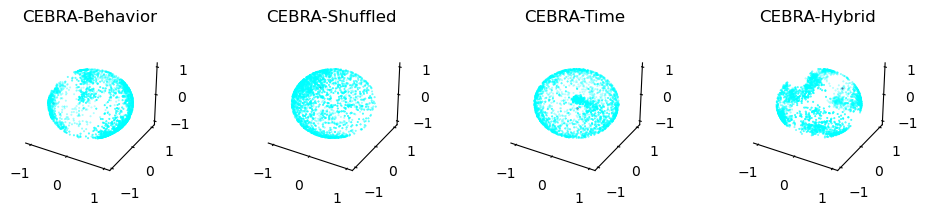

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

ax1=plot_cebra_both(ax1, cebra_dr_both_behavior_para, relativeMovementsIndex)
ax2=plot_cebra_both(ax2, cebra_dr_both_time_behavior_shuffle_para, relativeMovementsIndex)
ax3=plot_cebra_both(ax3, cebra_dr_both_time_para, relativeMovementsIndex)
ax4=plot_cebra_both(ax4, cebra_dr_both_time_behavior_para, relativeMovementsIndex)

ax1.set_title('CEBRA-Behavior')
ax2.set_title('CEBRA-Shuffled')
ax3.set_title('CEBRA-Time')
ax4.set_title('CEBRA-Hybrid')
plt.tight_layout()
plt.show()

<Axes: xlabel='Steps', ylabel='InfoNCE Loss'>

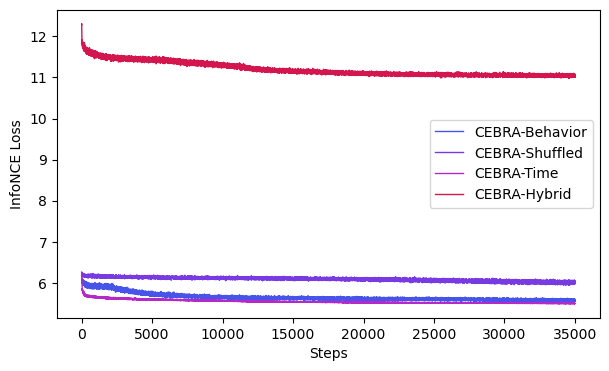

In [13]:
labels = ["CEBRA-Behavior", "CEBRA-Shuffled", "CEBRA-Time", "CEBRA-Hybrid"]

cebra.compare_models([cebra_dr_both_behavior, cebra_dr_both_time_behavior_shuffle, cebra_dr_both_time, cebra_dr_both_time_behavior], labels)